In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from cvnn import layers 

2023-08-29 10:29:19.866112: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 10:29:20.162116: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 10:29:20.163733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 10:29:22.511772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
data_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'
file_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'

In [4]:
# file_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'
# data_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'

In [5]:
mask = np.load(data_loc+'mask.npy')

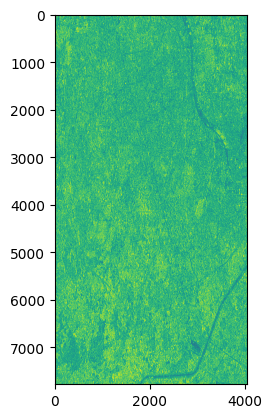

In [6]:
plt.imshow(mask)

In [7]:
input = np.load(file_loc+'input.npy')

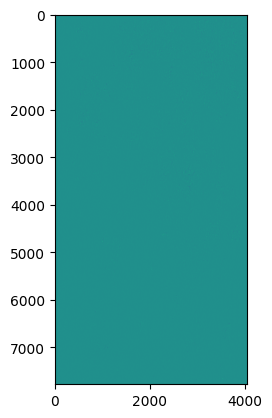

In [8]:
plt.imshow(np.real(input))

In [9]:
import patchify as pat

In [10]:
patches_inp = pat.patchify(input, (256, 256), step=256)
patches_mask = pat.patchify(mask, (256, 256), step=256)

In [11]:
patches_mask.shape

(30, 15, 256, 256)

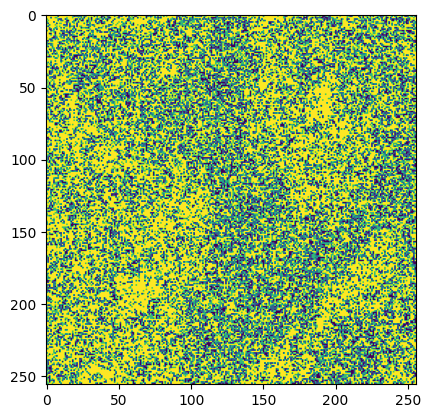

In [12]:
plt.imshow(patches_mask[25][0])

In [13]:
input_shape = (patches_inp[0][0].shape)
# input_shape = np.array(input_shape).reshape(-1, 256, 256, 1)
dtype  = tf.complex64

In [14]:
def _downsample_cvnn(inputs, units, dtype=dtype):
    c1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_initializer='ComplexHeNormal', padding='same')(inputs)
    c1 = layers.ComplexDropout(0.3)(c1)
    c1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_initializer='ComplexHeNormal', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2,2))(c1)
    return (c1, p1)

In [15]:
# def _downsample_cvnn(inputs, units):
#     c0 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(inputs)
#     c1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(c0)
#     c2 = layers.ComplexMaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)
#     return c0, c1, c2

In [16]:
def _upsample_cvnn(in1, in2, units, crop):
    t01 = layers.ComplexConv2DTranspose(units, kernel_size=2, strides=(2, 2), activation='relu', dtype=dtype)(in1)
    crop01 = tf.keras.layers.Cropping2D(cropping=(crop, crop))(in2)

    concat01 = tf.keras.layers.concatenate([t01, crop01], axis=-1)

    out1 = layers.ComplexConv2D(units, activation='relu', kernel_size=3, dtype=dtype)(concat01)
    out2 = layers.ComplexConv2D(units, activation='relu', kernel_size=3, dtype=dtype)(out1)
    return out1, out2

In [17]:
input_shape + (3,)

(256, 256, 3)

In [18]:
from cvnn.losses import ComplexMeanSquareError

In [19]:
def cvnn_unet():
    tf.random.set_seed(1)
    inputs = layers.ComplexInput(input_shape=input_shape + (3,))
    # c91, c92, c93 = _downsample_cvnn(inputs, 32, dtype)
    c0, c1, c2 = _downsample_cvnn(inputs, 64)
    c3, c4, c5 = _downsample_cvnn(c2, 128)
    c6, c7, c8 = _downsample_cvnn(c5, 256)
    c9, c10, c11 = _downsample_cvnn(c8, 512)

    c12 = layers.ComplexConv2D(1024, activation='relu', kernel_size=3)(c11)
    c13 = layers.ComplexConv2D(1024, activation='relu', kernel_size=3, padding='valid')(c12)

    # c14, c15 = _upsample_cvnn(c13, c10, 512, 4, dtype)
    # c16, c17 = _upsample_cvnn(c15, c7, 256, 16, dtype)
    # c18, c19 = _upsample_cvnn(c17, c4, 128, 40, dtype)
    # c20, c21 = _upsample_cvnn(c19, c1, 64, 88, dtype)

    outputs = layers.ComplexConv2D(4, kernel_size=1)(c13)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-net-cvnn")
    model.compile(loss=ComplexMeanSquareError(), optimizer="adam", metrics=["accuracy"])
    return model


In [20]:
help(layers.ComplexInput)

Help on class ComplexInput in module cvnn.layers.core:

class ComplexInput(keras.engine.input_layer.InputLayer, ComplexLayer)
 |  ComplexInput(input_shape=None, batch_size=None, dtype=tf.complex64, input_tensor=None, sparse=False, name=None, ragged=False, **kwargs)
 |  
 |  Method resolution order:
 |      ComplexInput
 |      keras.engine.input_layer.InputLayer
 |      keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.trackable.autotrackable.AutoTrackable
 |      tensorflow.python.trackable.base.Trackable
 |      keras.utils.version_utils.LayerVersionSelector
 |      ComplexLayer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_shape=None, batch_size=None, dtype=tf.complex64, input_tensor=None, sparse=False, name=None, ragged=False, **kwargs)
 |  
 |  get_real_equivalent(self)
 |      :return: Gets a real-valued COPY of the Complex Layer.
 |  
 |  ----------------------------------

In [21]:
help(layers.complex_input)

Help on function complex_input in module cvnn.layers.core:

complex_input(shape=None, batch_size=None, name=None, dtype=tf.complex64, sparse=False, tensor=None, ragged=False, **kwargs)
    `complex_input()` is used to instantiate a Keras tensor.
    A Keras tensor is a TensorFlow symbolic tensor object,
    which we augment with certain attributes that allow us to build a Keras model
    just by knowing the inputs and outputs of the model.
    For instance, if `a`, `b` and `c` are Keras tensors,
    it becomes possible to do:
    `model = Model(input=[a, b], output=c)`
    Arguments:
      shape: A shape tuple (integers), not including the batch size.
          For instance, `shape=(32,)` indicates that the expected input
          will be batches of 32-dimensional vectors. Elements of this tuple
          can be None; 'None' elements represent dimensions where the shape is
          not known.
      batch_size: optional static batch size (integer).
      name: An optional name string 

In [22]:
# model = tf.keras.models.Sequential()
# model.add(complex_layers.ComplexInput(input_shape=input_shape + (3,)))
# model.add(complex_layers.ComplexConv2D(32, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(64, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(128, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(256, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexFlatten())